In [1]:
#carregar os pacotes
%matplotlib inline
import momi		## momi2 analysis
import logging		## create log file
import pickle

In [2]:
#salvar o log
logging.basicConfig(level=logging.INFO,
                    filename="momi_log.txt")

In [8]:
%%bash
cat popmap_prim.txt

#conferir o arquivo popmap

MCI10_Teci_Prim_auri_MZUSP_81988 North
MCI11_Teci_Prim_auri_MZUSP_81989 North
MCI13_Teci_Prim_auri_MZUSP_98832 North
MCI14_Toep_Prim_auri_MZUSP_100445 South
MCI16_Toep_Prim_auri_MZUSP_12233 South
MCI17_Toep_Prim_auri_MZUSP_26704 South
MCI19_Toep_Prim_auri_MZUSP_30157 South
MCI1_Teci_Prim_auri_MZUSP_110797 North
MCI21_Toep_Prim_auri_MZUSP_3939 South
MCI2_Teci_Prim_auri_MZUSP_114969 North
MCI3_Teci_Prim_auri_MZUSP_114970 North
MCI4_Teci_Prim_auri_MZUSP_115213 North
MCI5_Teci_Prim_auri_MZUSP_115214 North
MCI6_Teci_Prim_auri_MZUSP_115215 North
MCI7_Teci_Prim_auri_MZUSP_115216 North
MCI88_Toep_Prim_auri_MZUSP_30155 South
MCI8_Teci_Prim_auri_MZUSP_115217 North
MCI9_Teci_Prim_auri_MZUSP_81200 South


In [10]:
%%bash
ls

pop_map_prim2.csv
popmap_prim.txt
prim95_momi2.bed
prim_95_total.vcf
prim95_unlinked.vcf
prim95_unlinked.vcf.gz
Untitled.ipynb
vcf2bed.R


In [19]:
%%bash
## bgzip performs a blockwise compression
## The -c flag directs bgzip to leave the original vcf file 
##   untouched and create a new file for the vcf.gz
## se o vcf foi salvo em vcf.gz no snpfiltR descomprir o arquivo antes de usar aqui, nao salvar direto como vcf no snpfiltR
bgzip -c prim95_unlinked.vcf > prim95_unlinked.vcf.gz

## tabix indexes the file for searching
tabix prim95_unlinked.vcf.gz
ls

pop_map_prim2.csv
popmap_prim.txt
prim95_momi2.bed
prim_95_total.vcf
prim95_unlinked.vcf
prim95_unlinked.vcf.gz
prim95_unlinked.vcf.gz.tbi
Untitled.ipynb
vcf2bed.R


In [17]:
%%bash

##transformei em bed no R, pacote bedr, função vcf2bed
## Print the first 10 lines of this file
head prim95_momi2.bed

uce-2814_MCI7_Teci_Prim_auri_MZUSP_115216 658 659
uce-841_MCI7_Teci_Prim_auri_MZUSP_115216 624 625
uce-115_MCI7_Teci_Prim_auri_MZUSP_115216 489 490
uce-4030_MCI7_Teci_Prim_auri_MZUSP_115216 142 143
uce-4538_MCI7_Teci_Prim_auri_MZUSP_115216 473 474
uce-7313_MCI7_Teci_Prim_auri_MZUSP_115216 616 617
uce-4316_MCI7_Teci_Prim_auri_MZUSP_115216 602 603
uce-748_MCI7_Teci_Prim_auri_MZUSP_115216 708 709
uce-1581_MCI7_Teci_Prim_auri_MZUSP_115216 614 615
uce-1063_MCI7_Teci_Prim_auri_MZUSP_115216 547 548


In [23]:
%%bash
python -m momi.read_vcf --no_aa --verbose prim95_unlinked.vcf.gz popmap_prim.txt prim_allele_counts.gz --bed prim95_momi2.bed
gunzip -c prim_allele_counts.gz | head

{
	"populations": ["N", "S"],
	"use_folded_sfs": true,
	"length": 425,
	"n_read_snps": 425,
	"n_excluded_snps": 0,
	"configs": [
		[[22, 0], [13, 1]],
		[[22, 0], [12, 2]],
		[[22, 0], [11, 3]],


In [24]:
%%bash
python -m momi.extract_sfs prim_sfs.gz 20 prim_allele_counts.gz

In [3]:
sfs = momi.Sfs.load("prim_sfs.gz")
print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
print("populations", sfs.populations)
print("percent missing data per population", sfs.p_missing)

Avg pairwise heterozygosity [[4.4025974  3.67032967]
 [4.21212121 4.3956044 ]
 [3.06926407 4.81318681]
 [3.38528139 2.84615385]
 [6.12987013 7.15384615]]
populations ('N', 'S')
percent missing data per population [0. 0.]


In [54]:
##Os modelos testados sao os mesmos de Bocalini et 2023 Mol Ecol

#Modelo 1a - isolamento sem migração com evento fundador na populacao do Sul

prim_model1a = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1a.set_data(sfs)

#prim_model1a.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1a.add_size_param("n_S", lower=5e3, upper=1e6)

prim_model1a.add_size_param("n_bt", lower=1e3, upper=5e4) 

prim_model1a.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1a.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1a.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1a.add_leaf("S", N=2e5, g="g_S")
prim_model1a.add_leaf("N", N=3e4)
prim_model1a.set_size("S", N="n_bt", t="tdiv", g=0)

prim_model1a.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1a.optimize(method='L-BFGS-B')



            fun: 0.4859692567612396
       hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00,  4.11723363e-08, -5.18896799e-04, -8.42384455e-02])
  kl_divergence: 0.4859692567612396
 log_likelihood: -1581.5570176107178
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 41
            nit: 33
           njev: 41
     parameters: ParamsDict({'n_bt': 22005.455523831755, 'tdiv': 43680.9989068148, 'g_S': 2.551310784110294e-05, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([ 9.99904568e+00, -4.85307011e+00,  2.55131078e-05,  1.61180957e+01])

In [56]:
### repetitions ### para encontrar o melhor valor de likelyhood

results = []
n_runs = 2
prim_model1a_copy = prim_model1a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1a.set_params(prim_model1a.get_params(),randomize=True)
    results.append(prim_model1a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, choose the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 2...
-1581.5570176107174
Starting run 2 out of 2...
-1581.5570176107174


In [57]:
#### output ## salvar os parametros em um .txt
file = open("bestrun_prim2.txt","a")
file.write("Model=model1a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo .pkl

prim_model1a = best_result
f = open("prim_model1a.pkl","wb")
pickle.dump(prim_model1a,f)
f.close()

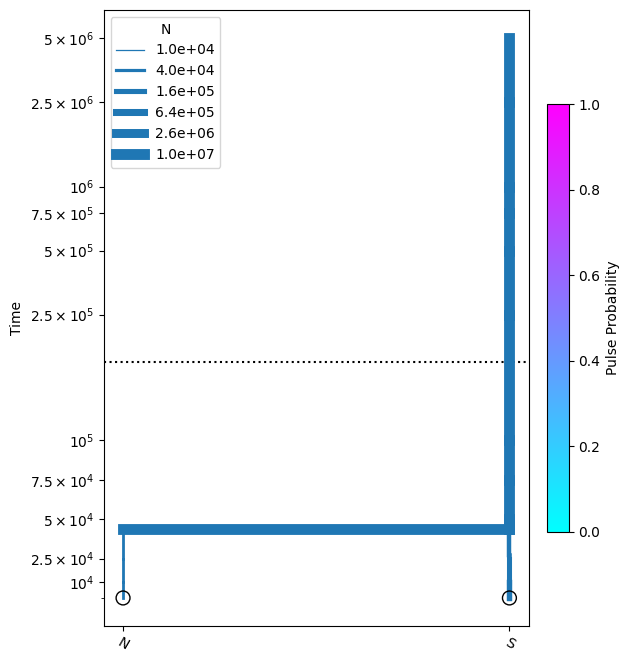

In [58]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [63]:
#Modelo 1b - isolamento sem migração com evento fundador na populacao do Norte - bt (bottleneck)
prim_model1b = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1b.set_data(sfs)

#prim_model1b.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1b.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1b.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1b.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1b.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1b.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1b.add_leaf("S", N=2e5)
prim_model1b.add_leaf("N", N=3e4, g="g_N")
prim_model1b.set_size("N", N="n_bt", t="tdiv", g=0)

prim_model1b.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1b.optimize(method='L-BFGS-B')

            fun: 1.0439181504763908
       hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00, -1.35265052e-03,  2.65361531e+03, -7.64839101e-02])
  kl_divergence: 1.0439181504763908
 log_likelihood: -1818.685297439657
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 12
            nit: 10
           njev: 12
     parameters: ParamsDict({'n_bt': 2055.829209029238, 'tdiv': 70183.32085552395, 'g_N': 1e-06, 'n_anc': 112178.86876871323})
         status: 0
        success: True
              x: array([ 7.62843455e+00, -4.32585346e+00,  1.00000000e-06,  1.16278499e+01])

In [64]:
### repetitions ###

results = []
n_runs = 2
prim_model1b_copy = prim_model1b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1b.set_params(prim_model1b.get_params(),randomize=True)
    results.append(prim_model1b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1b_copy.log_likelihood()
    print(lik)

best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 2...
-1582.7592208092383
Starting run 2 out of 2...
-1582.7592208092383


In [65]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1a = best_result
f = open("prim_model1b.pkl","wb")
pickle.dump(prim_model1a,f)
f.close()

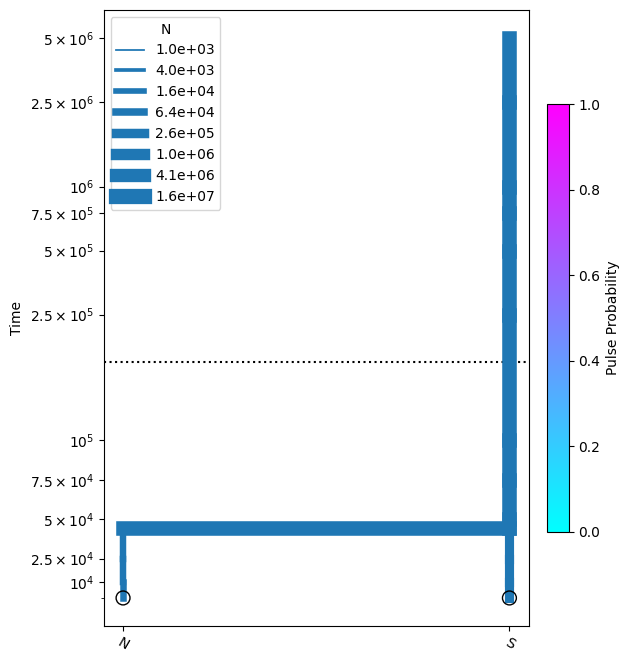

In [66]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [67]:
#Modelo 1c- isolamento sem migração com evento fundador no Sul e expansão no Norte

prim_model1c = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1c.set_data(sfs)

#prim_model1c.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1c.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1c.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1c.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1c.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1c.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1c.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1c.add_leaf("S", N=2e5, g="g_S")
prim_model1c.add_leaf("N", N=3e4, g="g_N")
prim_model1c.set_size("S", N="n_bt", t="tdiv", g=0)
prim_model1c.set_size("N",t="tdiv", g=0)

prim_model1c.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1c.optimize(method='L-BFGS-B')

            fun: 1.0888212827619794
       hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00, -2.67731878e-02, -1.01816551e-04,  1.44858765e+03,
       -8.74087154e-02])
  kl_divergence: 1.0888212827619794
 log_likelihood: -1837.7691286610323
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 14
            nit: 13
           njev: 14
     parameters: ParamsDict({'n_bt': 5393.38911011457, 'tdiv': 65808.5466774724, 'g_S': 1.0582584973098584e-05, 'g_N': 1e-06, 'n_anc': 65051.63853000143})
         status: 0
        success: True
              x: array([ 8.59292924e+00, -4.39621375e+00,  1.05825850e-05,  1.00000000e-06,
        1.10829367e+01])

In [68]:
### repetitions ###

results = []
n_runs = 5
prim_model1c_copy = prim_model1c.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1c.set_params(prim_model1c.get_params(),randomize=True)
    results.append(prim_model1c_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1c_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1c_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 5...
-1798.3718690983355
Starting run 2 out of 5...
-1582.2901921094237
Starting run 3 out of 5...
-1582.2901921089965
Starting run 4 out of 5...
-1582.2901921083183
Starting run 5 out of 5...
-1582.2901921082946


In [69]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1c" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1c = best_result
f = open("prim_model1c.pkl","wb")
pickle.dump(prim_model1c,f)
f.close()


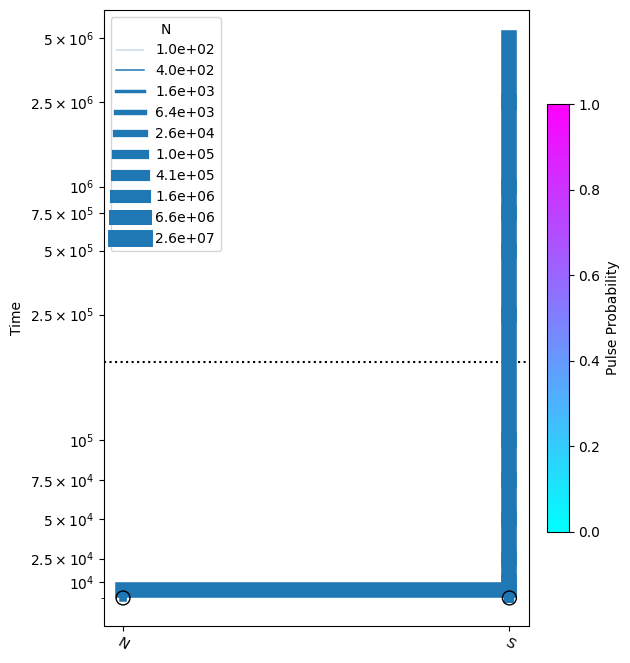

In [70]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1c_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [71]:
#Modelo 1d - isolamento sem migração com evento fundador na N e expansão na MA
prim_model1d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1d.set_data(sfs)

#prim_model1d.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1d.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1d.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1d.add_time_param("tdiv", lower=5e3, upper=5e6)

prim_model1d.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1d.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1d.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1d.add_leaf("S", N=2e5, g="g_S")
prim_model1d.add_leaf("N", N=3e4, g="g_N")
prim_model1d.set_size("S", t="tdiv", g=0)
prim_model1d.set_size("N",N="n_bt",t="tdiv", g=0)

prim_model1d.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1d.optimize()

            fun: 0.48610770309930657
            jac: array([ 0.00000000e+00, -6.14962528e-03,  6.52888205e-01, -1.12278491e+02,
       -8.41190646e-02])
  kl_divergence: 0.48610770309930657
 log_likelihood: -1581.6158573043963
        message: 'Max. number of function evaluations reached'
           nfev: 101
            nit: 19
     parameters: ParamsDict({'n_bt': 18077.990338833148, 'tdiv': 41529.36511819001, 'g_S': 2.9084723343906767e-05, 'g_N': 1.0000000000000243e-06, 'n_anc': 10000000.000000006})
         status: 3
        success: False
              x: array([ 9.80245047e+00, -4.91073617e+00,  2.90847233e-05,  1.00000000e-06,
        1.61180957e+01])

In [72]:
### repetitions ###

results = []
n_runs = 5
prim_model1d_copy = prim_model1d.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1d.set_params(prim_model1d.get_params(),randomize=True)
    results.append(prim_model1d_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1d_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1d_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 5...
-1581.5898908428585
Starting run 2 out of 5...
-1581.5898908425274
Starting run 3 out of 5...
-1581.5898907697388
Starting run 4 out of 5...
-1581.5898907611574
Starting run 5 out of 5...
-1581.5898907165054


In [73]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1d" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1d = best_result
f = open("prim_model1d.pkl","wb")
pickle.dump(prim_model1d,f)
f.close()

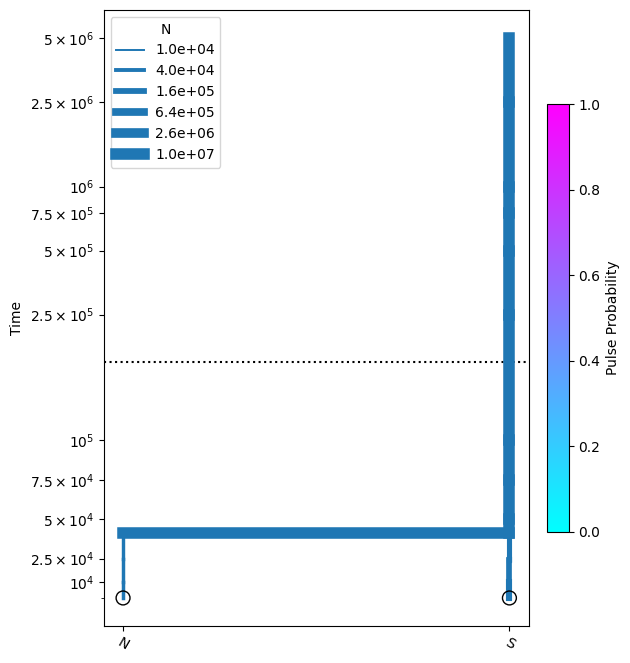

In [74]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1d_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [86]:
#Modelo 1e - isolamento com migração com evento fundador no Sul
prim_model1e = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1e.set_data(sfs)

#prim_model1e.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1e.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1e.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1e.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1e.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1e.add_pulse_param("mfrac_N_S", upper=.5)
prim_model1e.add_pulse_param("mfrac_S_N", upper=.5)

prim_model1e.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1e.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1e.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1e.add_leaf("S", N=2e5, g="g_S")
prim_model1e.add_leaf("N", N=3e4)
prim_model1e.set_size("S", N="n_bt", t="tdiv", g=0)

prim_model1e.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1e.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1e.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1e.optimize(method='L-BFGS-B')


            fun: 0.5465873703275065
       hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00, -1.09511850e-03,  2.29451261e-02,  4.84920950e-08,
        2.32880914e-02,  4.90749807e-02,  1.23446035e+03, -8.54908921e-02])
  kl_divergence: 0.5465873703275065
 log_likelihood: -1607.3197158763812
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 17
            nit: 11
           njev: 17
     parameters: ParamsDict({'n_bt': 42453.784108381034, 'tmig_N_S': 17512.704127631434, 'tmig_S_N': 44571.111565083316, 'mfrac_N_S': 0.2093440103245554, 'mfrac_S_N': 0.1462735124158285, 'tdiv': 89577.06653145218, 'g_S': 1e-06, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([ 1.06561713e+01, -5.98694004e+00, -4.83013965e+00, -1.32888409e+00,
       -1.76413263e+00, -4.69232054e+00,  1.00000000e-06,  1.61180957e+01])

In [87]:
### repetitions ###

results = []
n_runs = 3
prim_model1e_copy = prim_model1e.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1e.set_params(prim_model1e.get_params(),randomize=True)
    results.append(prim_model1e_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1e_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1e_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 3...
-1595.8150555446039
Starting run 2 out of 3...
-1582.9093232238376
Starting run 3 out of 3...
-1582.9093232238376


In [88]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1e" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

cary_model1e = best_result
f = open("prim_model1e.pkl","wb")
pickle.dump(cary_model1e,f)
f.close()


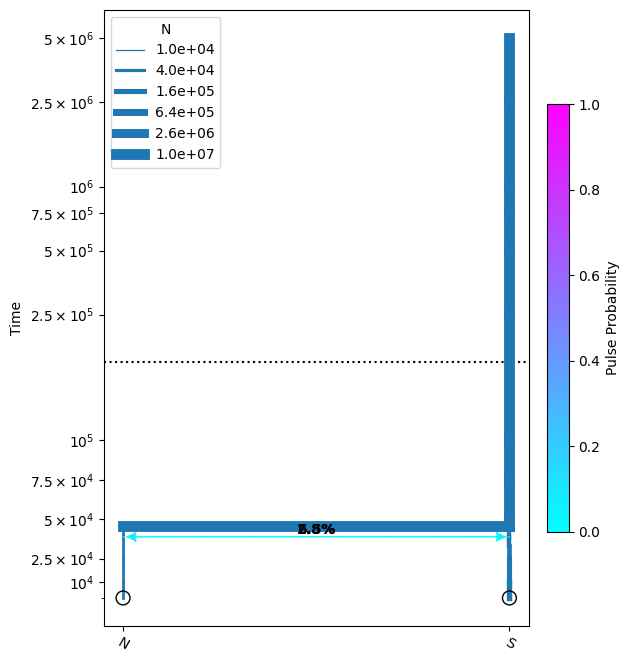

In [89]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1e_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [113]:
#Modelo 1f- isolamento com migração com evento fundador no Norte
prim_model1f = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1f.set_data(sfs)

#prim_model1f.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1f.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1f.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1f.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1f.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1f.add_pulse_param("mfrac_N_S", upper=.5)
prim_model1f.add_pulse_param("mfrac_S_N", upper=.5)

prim_model1f.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1f.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1f.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1f.add_leaf("S", N=2e5)
prim_model1f.add_leaf("N", N=3e4, g="g_N",)
prim_model1f.set_size("N", N="n_bt", t="tdiv", g=0)

prim_model1f.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1f.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1f.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1f.optimize(method='L-BFGS-B')

            fun: 0.4987153595975322
       hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00, -2.27401063e-03, -4.77146072e-06,  3.96142156e-05,
        1.49396287e-04, -2.94627973e-05,  3.91058175e-03, -8.44290562e-02])
  kl_divergence: 0.4987153595975322
 log_likelihood: -1586.9741113161422
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 53
            nit: 35
           njev: 53
     parameters: ParamsDict({'n_bt': 37606.58068380664, 'tmig_N_S': 10669.80895799772, 'tmig_S_N': 5469.0097641006005, 'mfrac_N_S': 0.16009534571484163, 'mfrac_S_N': 0.0004657132314427746, 'tdiv': 10833.109718554004, 'g_N': 0.0002210726984775339, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([ 1.05349343e+01, -6.77990153e+00, -9.27323048e+00, -1.65751883e+00,
       -7.67147467e+00, -1.03271858e+01,  2.21072698e-04,  1.61180957e+01])

In [114]:
### repetitions ###

results = []
n_runs = 4
prim_model1f_copy = prim_model1f.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1f.set_params(prim_model1f.get_params(),randomize=True)
    results.append(prim_model1f_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1f_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1f_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 4...
-1586.9741113067828
Starting run 2 out of 4...
-1586.974111301624
Starting run 3 out of 4...
-1586.9741112973281
Starting run 4 out of 4...
-1586.9741112940403


In [115]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1f" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1f = best_result
f = open("prim_model1f.pkl","wb")
pickle.dump(prim_model1f,f)
f.close()


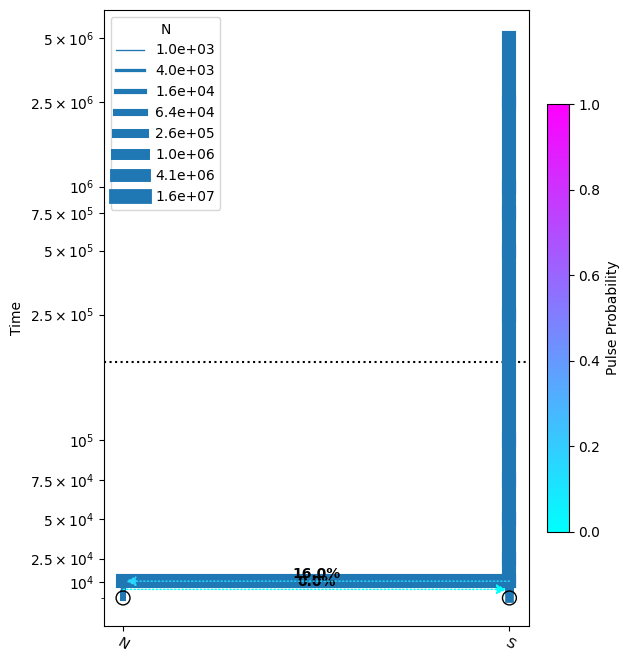

In [116]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1f_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [118]:
#Modelo 1g- isolamento com migração com evento fundador no Sul e expansão no Norte
prim_model1g = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1g.set_data(sfs)

#prim_model1g.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1g.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1g.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1g.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1g.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1g.add_pulse_param("mfrac_N_S", upper=.5)
prim_model1g.add_pulse_param("mfrac_S_N", upper=.5)

prim_model1g.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1g.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1g.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1g.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1g.add_leaf("S", N=2e5, g="g_S")
prim_model1g.add_leaf("N", N=3e4, g="g_N")
prim_model1g.set_size("S", N="n_bt", t="tdiv", g=0)
prim_model1g.set_size("N",t="tdiv", g=0)

prim_model1g.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1g.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1g.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1g.optimize(method='L-BFGS-B')

            fun: 1.042913169124064
       hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00,  6.78597143e-03, -2.27308549e-02, -1.96169394e-02,
        1.34533221e-02,  1.77158982e-02,  1.05110444e+03,  7.10789113e+03,
       -3.37076804e-02])
  kl_divergence: 1.042913169124064
 log_likelihood: -1818.2581803649182
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 10
            nit: 8
           njev: 10
     parameters: ParamsDict({'n_bt': 21533.2475726285, 'tmig_N_S': 32324.007044740767, 'tmig_S_N': 86178.53109410426, 'mfrac_N_S': 0.25792284852149033, 'mfrac_S_N': 0.4999999999749789, 'tdiv': 155101.16291194744, 'g_S': 1e-06, 'g_N': 1e-06, 'n_anc': 153242.67572054308})
         status: 0
        success: True
              x: array([ 9.97735342e+00, -5.20294171e+00, -4.10315640e+00, -1.05679271e+00,
       -1.00084607e-10, -4.25269705e+00,  1.00000000e-06,  1.00000000e-06,
        1.19397781e+01])

In [120]:
### repetitions ###

results = []
n_runs = 3
prim_model1g_copy = prim_model1g.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1g.set_params(prim_model1g.get_params(),randomize=True)
    results.append(prim_model1g_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1g_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1g_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 3...
-1779.2130443040965
Starting run 2 out of 3...
-1594.2940011786911
Starting run 3 out of 3...
-1594.2938622643346


In [121]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1g" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1g = best_result
f = open("prim_model1g.pkl","wb")
pickle.dump(prim_model1g,f)
f.close()

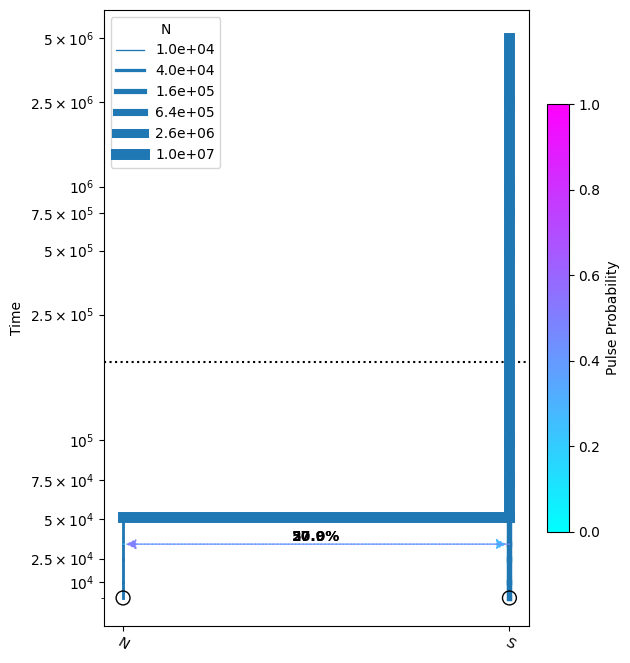

In [122]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1g_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [125]:
#Modelo 1h - isolamento com migração com evento fundador no N e expansão no Sul 
prim_model1h = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model1h.set_data(sfs)

#prim_model1h.add_size_param("n_N", lower=5e3, upper=1e6)
#prim_model1h.add_size_param("n_S", lower=5e3, upper=1e6)
prim_model1h.add_size_param("n_bt", lower=1e3, upper=5e4)

prim_model1h.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model1h.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model1h.add_pulse_param("mfrac_N_S", upper=.5)
prim_model1h.add_pulse_param("mfrac_S_N", upper=.5)

prim_model1h.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

prim_model1h.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model1h.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model1h.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model1h.add_leaf("S", N=2e5, g="g_S")
prim_model1h.add_leaf("N", N=3e4, g="g_N")
prim_model1h.set_size("N",t="tdiv", N="n_bt", g=0)
prim_model1h.set_size("S",t="tdiv", g=0)

prim_model1h.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model1h.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model1h.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model1h.optimize(method='L-BFGS-B')


            fun: 0.48675074559431075
       hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 0.00000000e+00, -8.87211388e-04, -7.84833929e-19,  1.01270800e-05,
        1.15839638e-35,  1.83460831e-05, -4.33042095e-02, -2.36601782e-02,
       -8.49597161e-02])
  kl_divergence: 0.48675074559431075
 log_likelihood: -1581.889150364773
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 98
            nit: 68
           njev: 98
     parameters: ParamsDict({'n_bt': 34824.138060699224, 'tmig_N_S': 24799.36882809484, 'tmig_S_N': 5007.436977425903, 'mfrac_N_S': 0.4529452913662723, 'mfrac_S_N': 3.724011566530764e-35, 'tdiv': 24803.28049893542, 'g_S': 8.134806935997747e-05, 'g_N': 4.1484237915709145e-05, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([ 1.04580660e+01, -5.52657092e+00, -1.34174820e+01, -1.88777465e-01,
       -7.92756768e+01, -1.40560109e+01,  8.13480694e-05,  4.14842379e

In [126]:
### repetitions ###

results = []
n_runs = 5
prim_model1h_copy = prim_model1h.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model1h.set_params(prim_model1h.get_params(),randomize=True)
    results.append(prim_model1h_copy.optimize(method='L-BFGS-B'))
    lik=prim_model1h_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model1h_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 5...
-1581.8891503579484
Starting run 2 out of 5...
-1581.8891503537716
Starting run 3 out of 5...
-1581.8891503002717
Starting run 4 out of 5...
-1581.889150300112
Starting run 5 out of 5...
-1581.889150300112


In [127]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model1h" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model1h = best_result
f = open("prim_model1h.pkl","wb")
pickle.dump(prim_model1h,f)
f.close()


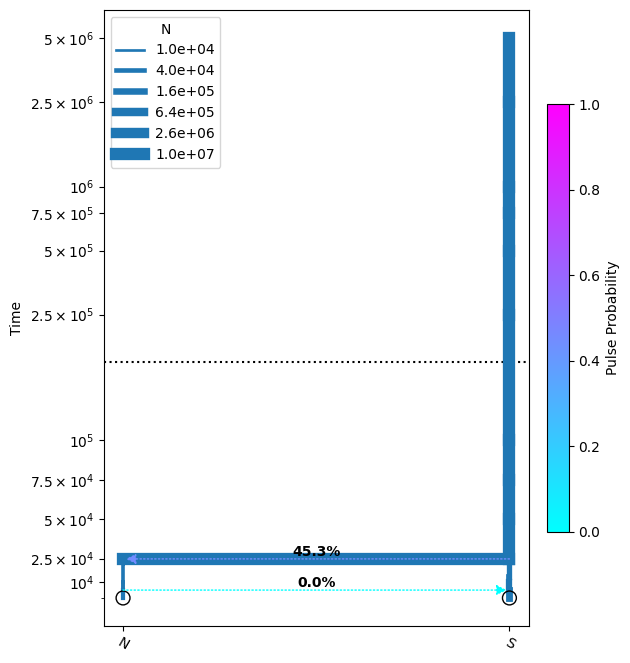

In [128]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model1h_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [129]:
#Modelo 2a - isolamento sem migração como expansão do S
prim_model2a = momi.DemographicModel(N_e=1e5, gen_time=4.72,muts_per_gen=2.5e-9)

prim_model2a.set_data(sfs)
prim_model2a.add_time_param("tdiv",lower=5e3,upper=5e6)
prim_model2a.add_growth_param("g_S", lower=1e-6, upper=1e-3)

prim_model2a.add_leaf("N", N=2e5)
prim_model2a.add_leaf("S", N=3e4, g="g_S")
prim_model2a.set_size("S", t="tdiv", g=0)
prim_model2a.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model2a.move_lineages("N", "S", t="tdiv")

prim_model2a.optimize(method='L-BFGS-B')


            fun: 1.3664792813346798
       hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
            jac: array([-3.21746158e-07,  1.01354071e+04,  0.00000000e+00])
  kl_divergence: 1.3664792813346798
 log_likelihood: -1955.7737780544298
        message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
           nfev: 7
            nit: 6
           njev: 7
     parameters: ParamsDict({'tdiv': 56495.21545483313, 'g_S': 1e-06, 'n_anc': 56952.870677825376})
         status: 0
        success: True
              x: array([-4.56434093e+00,  1.00000000e-06,  1.09499794e+01])

In [130]:
### repetitions ###

results = []
n_runs = 10
prim_model2a_copy = prim_model2a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2a.set_params(prim_model2a.get_params(),randomize=True)
    results.append(prim_model2a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 10...
-1955.7737780544298
Starting run 2 out of 10...
-1955.7737780544298
Starting run 3 out of 10...
-1955.7737780544298
Starting run 4 out of 10...
-1955.7737780544298
Starting run 5 out of 10...
-1955.7737780544298
Starting run 6 out of 10...
-1955.7737780544298
Starting run 7 out of 10...
-1955.7737780544298
Starting run 8 out of 10...
-1955.7737780544298
Starting run 9 out of 10...
-1955.7737780544298
Starting run 10 out of 10...
-1955.7737780544298


In [131]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model2a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2a = best_result
f = open("prim_model2a.pkl","wb")
pickle.dump(prim_model2a,f)
f.close()


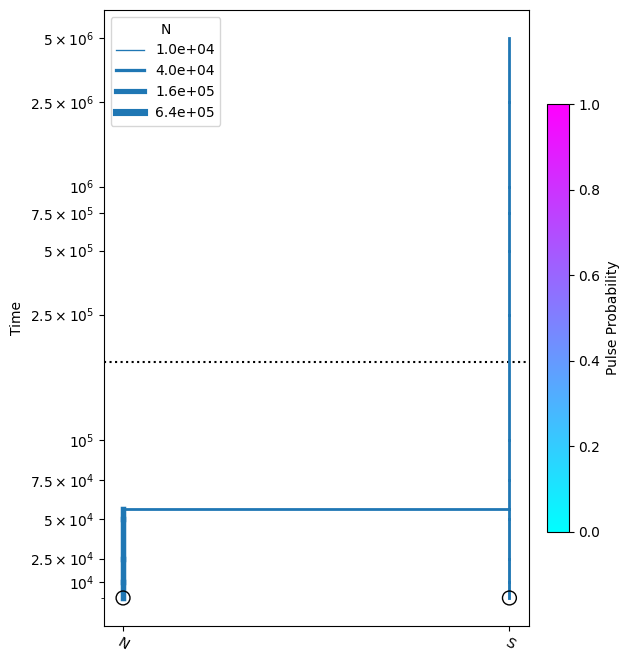

In [132]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [134]:
#Modelo 2b - isolamento sem migração como expansão da N

prim_model2b = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2b.set_data(sfs)

#prim_model2b.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2b.add_size_param("n_S",lower=5e3,upper=1e6)
prim_model2b.add_time_param("tdiv", lower=5e3,upper=5e6)
prim_model2b.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model2b.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model2b.add_leaf("S",N=2e5)
prim_model2b.add_leaf("N", N=3e4, g="g_N")
prim_model2b.set_size("N", t="tdiv", g=0)

prim_model2b.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model2b.optimize(method='L-BFGS-B')


            fun: 1.0198371362538097
       hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
            jac: array([-3.32146966e-03,  2.24734200e+03, -8.32612319e-02])
  kl_divergence: 1.0198371362538097
 log_likelihood: -1808.45086639506
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 10
            nit: 8
           njev: 10
     parameters: ParamsDict({'tdiv': 65417.01161223063, 'g_N': 1e-06, 'n_anc': 152383.79896221907})
         status: 0
        success: True
              x: array([-4.40275273e+00,  1.00000000e-06,  1.19341576e+01])

In [135]:
### repetitions ###

results = []
n_runs = 10
prim_model2b_copy = prim_model2b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2b.set_params(prim_model2b.get_params(),randomize=True)
    results.append(prim_model2b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2b_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1582.7592208012181
Starting run 2 out of 10...
-1582.7592208012181
Starting run 3 out of 10...
-1582.7592208012181
Starting run 4 out of 10...
-1582.7592208012181
Starting run 5 out of 10...
-1582.7592208012181
Starting run 6 out of 10...
-1582.7592208012181
Starting run 7 out of 10...
-1582.7592208012181
Starting run 8 out of 10...
-1582.7592208012181
Starting run 9 out of 10...
-1582.7592208012181
Starting run 10 out of 10...
-1582.7592208012181


In [136]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model2b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2b = best_result
f = open("prim_model2b.pkl","wb")
pickle.dump(prim_model2b,f)
f.close()

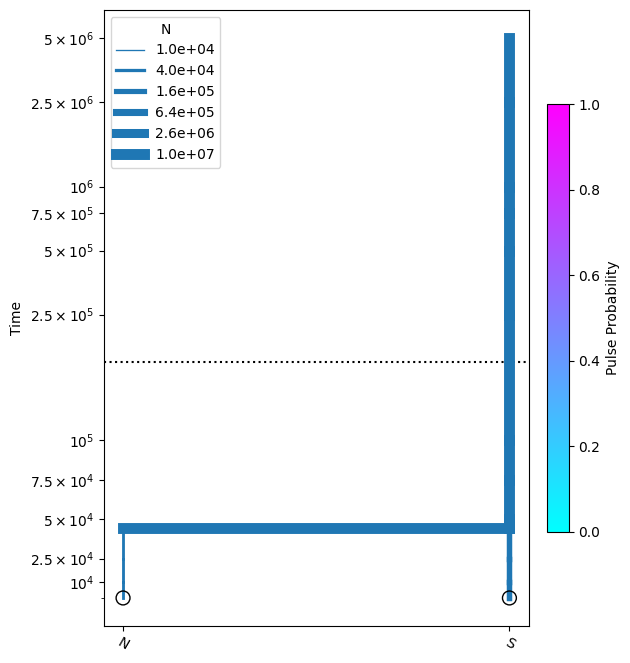

In [137]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [148]:
#Modelo 2c - migração para os dois lados com expansão do S
prim_model2c = momi.DemographicModel(N_e=1e5,gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2c.set_data(sfs)

prim_model2c.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2c.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2c.add_pulse_param("mfrac_N_S", upper=.5)
prim_model2c.add_pulse_param("mfrac_S_N", upper=.5)

prim_model2c.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])

#prim_model2c.add_size_param("n_S", lower=5e3,upper=1e6)
#prim_model2c.add_size_param("n_N", lower=5e3,upper=1e6)
prim_model2c.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model2c.add_size_param("n_anc", lower=5e3, upper=1e7)

prim_model2c.add_leaf("N", N=2e5)
prim_model2c.add_leaf("S", N=3e4, g="g_S")
prim_model2c.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2c.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2c.set_size("S", t="tdiv", g=0)

prim_model2c.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model2c.optimize()

            fun: 0.6696640863764611
            jac: array([ 1.72215620e-11,  2.06206515e-07,  5.89634815e-09, -2.82490178e-10,
        4.82881719e-08,  9.86220425e+02, -7.93628509e-02])
  kl_divergence: 0.6696640863764611
 log_likelihood: -1659.627320197187
        message: 'Local minimum reached (|pg| ~= 0)'
           nfev: 72
            nit: 17
     parameters: ParamsDict({'tmig_N_S': 5015.4944606390445, 'tmig_S_N': 5000.877038168995, 'mfrac_N_S': 9.576123990576903e-09, 'mfrac_S_N': 0.1477504801207887, 'tdiv': 44259.50235273558, 'g_S': 1.0000000000000243e-06, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([-1.26834623e+01, -1.55551526e+01, -1.84639929e+01, -1.75235444e+00,
       -4.83850311e+00,  1.00000000e-06,  1.61180957e+01])

In [149]:
### repetitions ###

results = []
n_runs = 3
prim_model2c_copy = prim_model2c.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2c.set_params(prim_model2c.get_params(),randomize=True)
    results.append(prim_model2c_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2c_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2c_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 3...
-1659.627320197187
Starting run 2 out of 3...
-1659.627320197187
Starting run 3 out of 3...
-1659.627320197187


In [150]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model2c" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2c = best_result
f = open("prim_model2c.pkl","wb")
pickle.dump(prim_model2c,f)
f.close()


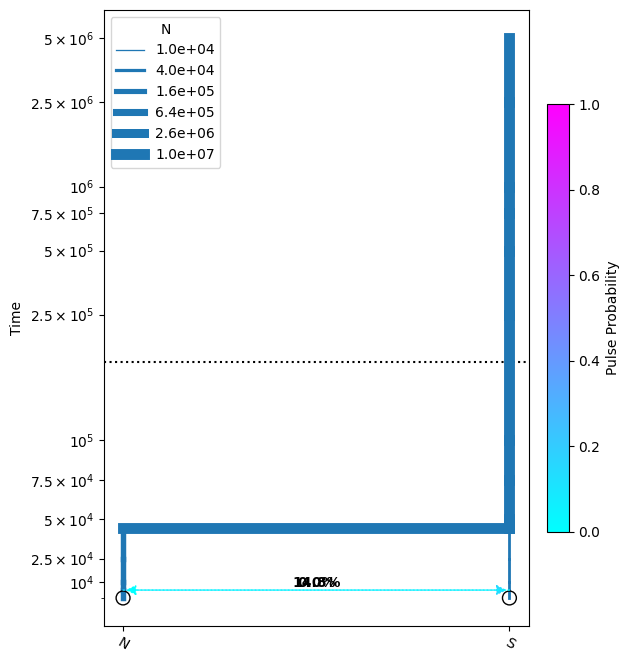

In [151]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2c_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [160]:
#Modelo 2d -migração para os dois lados com expansão do N
prim_model2d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2d.set_data(sfs)

prim_model2d.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2d.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2d.add_pulse_param("mfrac_N_S", upper=.5)
prim_model2d.add_pulse_param("mfrac_S_N", upper=.5)

#prim_model2d.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2d.add_size_param("n_S", lower=5e3,upper=1e6)
prim_model2d.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model2d.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model2d.add_size_param("n_anc", lower=5e3, upper=1e7)
prim_model2d.add_leaf("S",N=2e5)
prim_model2d.add_leaf("N", N=3e4, g="g_N")
prim_model2d.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2d.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2d.set_size("N", t="tdiv", g=0)

prim_model2d.move_lineages("N", "S", t="tdiv", N="n_anc")
prim_model2d.optimize(method='L-BFGS-B')

            fun: 1.0597418784016077
       hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
            jac: array([-1.11241710e-02, -2.01150700e-02, -7.41948884e-02,  2.68342079e-02,
        4.74119727e-03,  1.46549181e+04, -2.48243866e-02])
  kl_divergence: 1.0597418784016077
 log_likelihood: -1825.4103818078743
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 8
            nit: 7
           njev: 8
     parameters: ParamsDict({'tmig_N_S': 37197.20443717909, 'tmig_S_N': 80604.36712354858, 'mfrac_N_S': 0.47672459787897753, 'mfrac_S_N': 0.34877657259325295, 'tdiv': 615548.0498915104, 'g_N': 1e-06, 'n_anc': 93033.054218858})
         status: 0
        success: True
              x: array([-5.03784631e+00, -4.17542692e+00, -9.31689457e-02, -6.24421266e-01,
       -2.10365844e+00,  1.00000000e-06,  1.14407101e+01])

In [161]:
### repetitions ###

results = []
n_runs = 5
prim_model2d_copy = prim_model2d.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2d.set_params(prim_model2d.get_params(),randomize=True)
    results.append(prim_model2d_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2d_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2d_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 5...
-1811.30047962775
Starting run 2 out of 5...
-1805.2788512033794
Starting run 3 out of 5...
-1800.026251325082
Starting run 4 out of 5...
-1795.96815020474
Starting run 5 out of 5...
-1781.4821332667732


In [155]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model2d" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2d = best_result
f = open("prim_model2d.pkl","wb")
pickle.dump(prim_model2d,f)
f.close()

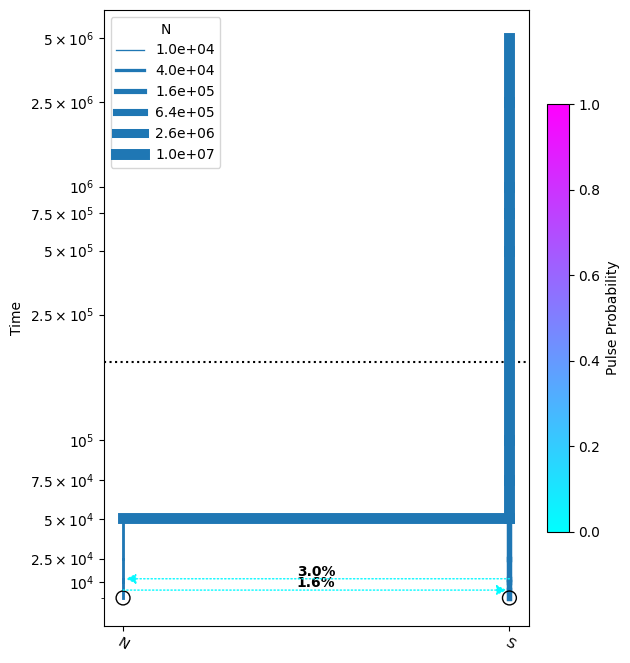

In [156]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2d_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [165]:
#Modelo 2e -migração para os dois lados com expansão das duas pops
prim_model2e = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2e.set_data(sfs)

prim_model2e.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2e.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2e.add_pulse_param("mfrac_N_S", upper=.5)
prim_model2e.add_pulse_param("mfrac_S_N", upper=.5)


#prim_model2e.add_size_param("n_S", lower=5e3,upper=1e6)
prim_model2e.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model2e.add_growth_param("g_N", lower=1e-6, upper=1e-3)
prim_model2e.add_growth_param("g_S", lower=1e-6, upper=1e-3)
prim_model2e.add_size_param("n_anc", lower=5e3,upper=1e7)

prim_model2e.add_leaf("S",N=2e5, g="g_S")
prim_model2e.add_leaf("N", N=3e4, g="g_N")
prim_model2e.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2e.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2e.set_size("N", t="tdiv", g=0)
prim_model2e.set_size("S", t="tdiv", g=0)

prim_model2e.move_lineages("N", "S", t="tdiv", N="n_anc")
prim_model2e.optimize(method='L-BFGS-B')

            fun: 1.1433144485855957
       hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
            jac: array([-8.18859355e-03, -1.02817087e-07, -1.22836518e-04,  5.51272840e-02,
       -3.70976703e-03,  3.41196435e+03,  1.59560017e-03, -5.58436355e-02])
  kl_divergence: 1.1433144485855957
 log_likelihood: -1860.9287241360691
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 22
            nit: 15
           njev: 22
     parameters: ParamsDict({'tmig_N_S': 66948.25599834153, 'tmig_S_N': 5000.054798905054, 'mfrac_N_S': 0.01118858438315991, 'mfrac_S_N': 0.28469457128052966, 'tdiv': 93438.74103998969, 'g_N': 1e-06, 'g_S': 2.082784495667389e-05, 'n_anc': 67669.85898644812})
         status: 0
        success: True
              x: array([-4.37741363e+00, -1.83280330e+01, -4.48160962e+00, -9.21292699e-01,
       -5.22154301e+00,  1.00000000e-06,  2.08278450e-05,  1.11223961e+01])

In [166]:
### repetitions ###

results = []
n_runs = 10
prim_model2e_copy = prim_model2e.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model2e.set_params(prim_model2e.get_params(),randomize=True)
    results.append(prim_model2e_copy.optimize(method='L-BFGS-B'))
    lik=prim_model2e_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model2e_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1725.070717842726
Starting run 2 out of 10...
-1582.323505546855
Starting run 3 out of 10...
-1582.3235054516317
Starting run 4 out of 10...
-1582.3235053510728
Starting run 5 out of 10...
-1582.323505329537
Starting run 6 out of 10...
-1582.3235053250428
Starting run 7 out of 10...
-1582.3235053246042
Starting run 8 out of 10...
-1582.3235053223193
Starting run 9 out of 10...
-1582.3235053223193
Starting run 10 out of 10...
-1582.3235053223193


In [167]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model2e" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model2d = best_result
f = open("prim_model2e.pkl","wb")
pickle.dump(prim_model2d,f)
f.close()

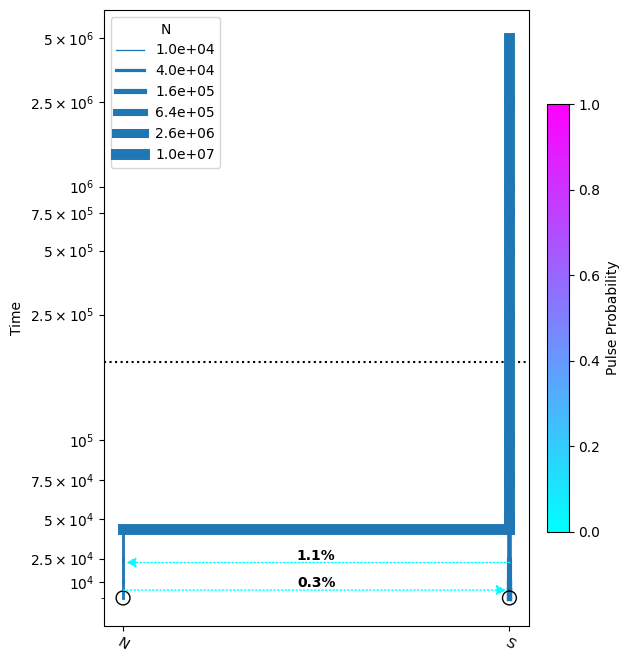

In [168]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model2e_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [169]:
#Modelo 3a - isolamento sem migração
prim_model3a = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model3a.set_data(sfs)

prim_model3a.add_time_param("tdiv", lower=5e3, upper=5e6)
prim_model3a.add_size_param("n_anc", lower=5e3, upper=1e7)
prim_model3a.add_leaf("S", N=2e5)
prim_model3a.add_leaf("N", N=3e4)

prim_model3a.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model3a.optimize()

            fun: 0.4886080809361545
            jac: array([ 3.27755857e-11, -8.37423799e-02])
  kl_divergence: 0.4886080809361545
 log_likelihood: -1582.6785178850566
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 15
            nit: 5
     parameters: ParamsDict({'tdiv': 45265.40410401317, 'n_anc': 10000000.000000006})
         status: 1
        success: True
              x: array([-4.81260624, 16.11809565])

In [170]:
### repetitions ###

results = []
n_runs = 10
prim_model3a_copy = prim_model3a.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model3a.set_params(prim_model3a.get_params(),randomize=True)
    results.append(prim_model3a_copy.optimize(method='L-BFGS-B'))
    lik=prim_model3a_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model3a_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)


Starting run 1 out of 10...
-1582.6785178850566
Starting run 2 out of 10...
-1582.6785178850566
Starting run 3 out of 10...
-1582.6785178850566
Starting run 4 out of 10...
-1582.6785178850566
Starting run 5 out of 10...
-1582.6785178850566
Starting run 6 out of 10...
-1582.6785178850566
Starting run 7 out of 10...
-1582.6785178850566
Starting run 8 out of 10...
-1582.6785178850566
Starting run 9 out of 10...
-1582.6785178850566
Starting run 10 out of 10...
-1582.6785178850566


In [172]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model3a" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model3a = best_result
f = open("prim_model3a.pkl","wb")
pickle.dump(prim_model3a,f)
f.close()


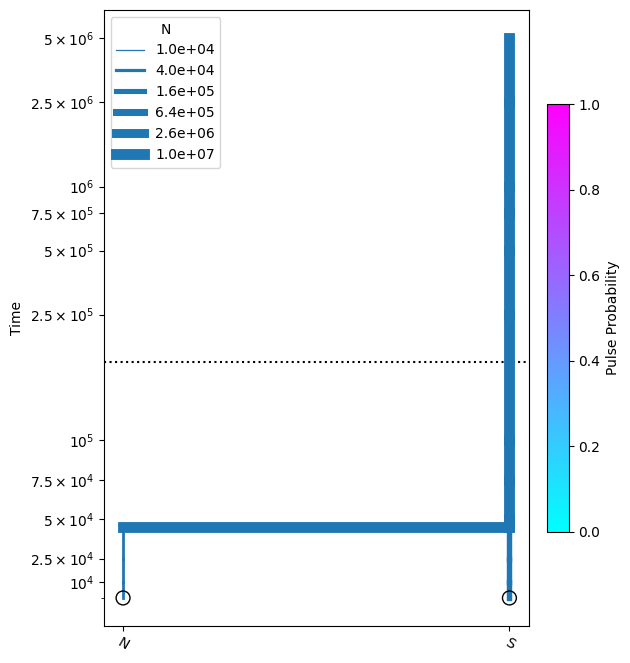

In [173]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model3a_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [174]:
#Modelo 3b - migração ambos os lados, sem expasão
prim_model3b = momi.DemographicModel(N_e=1e5,gen_time=4.72, muts_per_gen=2.5e-9)

prim_model3b.set_data(sfs)

prim_model3b.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model3b.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model3b.add_pulse_param("mfrac_N_S", upper=.5)
prim_model3b.add_pulse_param("mfrac_S_N", upper=.5)

prim_model3b.add_time_param("tdiv", lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model3b.add_size_param("n_anc", lower=5e3, upper=1e7)
#prim_model3b.add_size_param("n_S", lower=5e3,upper=1e6)
#prim_model3b.add_size_param("n_N", lower=5e3,upper=1e6)

prim_model3b.add_leaf("N", N=2e5)
prim_model3b.add_leaf("S", N=3e4)
prim_model3b.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model3b.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")

prim_model3b.move_lineages("N", "S", t="tdiv", N="n_anc")

prim_model3b.optimize(method='L-BFGS-B')


            fun: 0.6731777639565873
       hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
            jac: array([ 5.05791584e-03, -7.29207042e-04,  4.77395874e-15,  4.73227425e-11,
        3.40369900e-20, -7.94489122e-02])
  kl_divergence: 0.6731777639565873
 log_likelihood: -1661.1206331687406
        message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
           nfev: 114
            nit: 23
           njev: 114
     parameters: ParamsDict({'tmig_N_S': 33265.68227933087, 'tmig_S_N': 33265.682049189134, 'mfrac_N_S': 0.4998811448291003, 'mfrac_S_N': 0.3678800636117294, 'tdiv': 33265.68227933087, 'n_anc': 10000000.000000006})
         status: 0
        success: True
              x: array([-5.16886940e+00, -5.16886940e+00, -4.75420693e-04, -5.41322178e-01,
       -4.61189412e+01,  1.61180957e+01])

In [175]:
### repetitions ###

results = []
n_runs = 5
prim_model3b_copy = prim_model3b.copy()
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    prim_model3b.set_params(prim_model3b.get_params(),randomize=True)
    results.append(prim_model3b_copy.optimize(method='L-BFGS-B'))
    lik=prim_model3b_copy.log_likelihood()
    print(lik)

# sort results according to log likelihood, primk the best one
best_result = sorted(results, key=lambda r: r.log_likelihood, reverse=True)[0]

prim_model3b_copy.set_params(best_result.parameters)
best_result
nparams= len(best_result.parameters)

Starting run 1 out of 5...


/home/fernanda/miniconda3/envs/momi2_py38/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


-1661.120633167722
Starting run 2 out of 5...
-1661.120633167722
Starting run 3 out of 5...
-1661.120633167722
Starting run 4 out of 5...
-1661.120633167722
Starting run 5 out of 5...
-1661.120633167722


In [176]:
#### output
file = open("bestrun_prim2.txt","a")
file.write("Model=model3b" '\n')
file.write("Log_likelihood=")
file.write(str(best_result.log_likelihood))
file.write('\n')
file.write("n_parameters=")
file.write(str(nparams))
file.write('\n')
file.write("Parameters_estimates:" '\n')
file.write(str(best_result.parameters))
file.write('\n')
file.write('\n')
file.close()

## exportar o melhor modelo

prim_model3b = best_result
f = open("prim_model3b.pkl","wb")
pickle.dump(prim_model3b,f)
f.close()

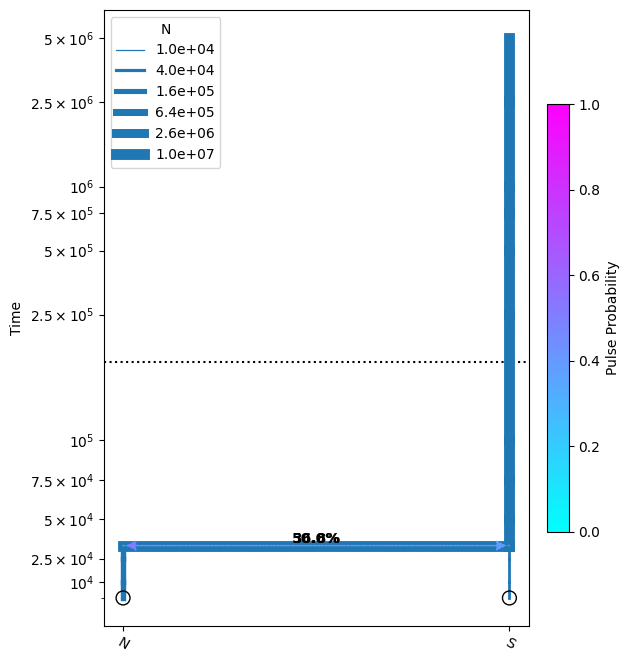

In [177]:
yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2.5e6, 5e6]

fig = momi.DemographyPlot(
    prim_model3b_copy, ["N", "S"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [178]:
%%bash
awk -f list_to_table.awk bestrun_prim2.txt > table_logs_prim2.csv

In [179]:
import pandas as pd

import numpy as np

df1 = pd.read_csv('table_logs_prim2.csv', sep='\t')

df1['AICs'] = (2*df1['n_parameters'] - 2*df1['Log_likelihood'])

df1['Delta_AIC'] = np.array(df1['AICs']) - np.min(df1['AICs'])

df1['weight_AICs'] = np.exp(-0.5*df1['Delta_AIC'])

df1.to_csv('table_AICs_prim_final2.csv', sep='\t')

In [149]:
## Melhor modelo 3a ou 2d - vou fazer com o 2d
#Modelo 2d -migração para os dois lados com expansão do N
prim_model2d = momi.DemographicModel(N_e=1e5, gen_time=4.72, muts_per_gen=2.5e-9)

prim_model2d.set_data(sfs)

prim_model2d.add_time_param("tmig_N_S", lower=5e3, upper=5e6)
prim_model2d.add_time_param("tmig_S_N", lower=5e3, upper=5e6)
prim_model2d.add_pulse_param("mfrac_N_S", upper=.2)
prim_model2d.add_pulse_param("mfrac_S_N", upper=.2)

#prim_model2d.add_size_param("n_N", lower=5e3,upper=1e6)
#prim_model2d.add_size_param("n_S", lower=5e3,upper=1e6)
prim_model2d.add_time_param("tdiv",lower=5e3, upper=5e6, lower_constraints=["tmig_N_S", "tmig_S_N"])
prim_model2d.add_growth_param("g_N", lower=1e-6, upper=1e-3)

prim_model2d.add_leaf("S",N=2e5)
prim_model2d.add_leaf("N", N=3e4, g="g_N")
prim_model2d.move_lineages("N", "S", t="tmig_N_S", p="mfrac_N_S")
prim_model2d.move_lineages("S", "N", t="tmig_S_N", p="mfrac_S_N")
prim_model2d.set_size("N", t="tdiv", g=0)

prim_model2d.move_lineages("N", "S", t="tdiv")


In [151]:
import numpy as np
np.random.seed(100)  # Escolha qualquer número inteiro como semente

n_bootstraps = 10

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}-th bootstrap out of {n_bootstraps}")
    # make copies of the original model to avoid changing them
    prim_model2d_copy = prim_model2d.copy()

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    prim_model2d_copy.set_data(resampled_sfs)
    #add_pulse_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    
    params = prim_model2d_copy.get_params()
    numeric_params = {k: float(v) if hasattr(v, '__float__') else v for k, v in params.items()}
    prim_model2d_copy.set_params(numeric_params, randomize=True)
    prim_model2d_copy.optimize(method='L-BFGS-B')
    # initialize parameters from submodel, randomizing the new parameters
    #add_pulse_copy.set_params(prim_model2db_copy.get_params(),,randomize=True)
    #add_pulse_copy.optimize()

    bootstrap_results.append(prim_model2d_copy.get_params())

Fitting 1-th bootstrap out of 10
Fitting 2-th bootstrap out of 10
Fitting 3-th bootstrap out of 10
Fitting 4-th bootstrap out of 10
Fitting 5-th bootstrap out of 10
Fitting 6-th bootstrap out of 10
Fitting 7-th bootstrap out of 10
Fitting 8-th bootstrap out of 10
Fitting 9-th bootstrap out of 10
Fitting 10-th bootstrap out of 10


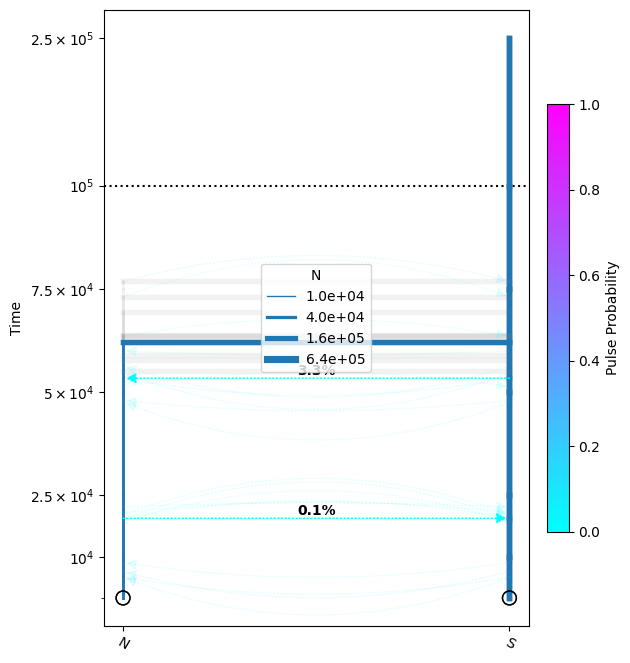

In [154]:
import matplotlib.pyplot as plt

import pickle
yticks=[1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5]
fig = momi.DemographyPlot(
    prim_model2d_copy, ["N", "S"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)

# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/10)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="center")
plt.savefig('bootstrap_model2d_prim.pdf')

In [152]:
import pandas as pd
df = pd.DataFrame(bootstrap_results)
df
df.to_csv("bootstrap_prim_model2d.csv", sep=',')